In [ ]:
import math
import random
import time as tm
from tqdm import tqdm
from matplotlib import pyplot as plt


class SolveTSPUsingACO:
    class Edge:
        def __init__(self, a, b, weight, initial_pheromone):
            self.a = a
            self.b = b
            if weight == 0:
                weight = 1e-10
            self.weight = weight
            self.pheromone = initial_pheromone

    class Ant:
        def __init__(self, alpha, beta, num_nodes, edges):
            self.alpha = alpha
            self.beta = beta
            self.num_nodes = num_nodes
            self.edges = edges
            self.tour = None
            self.distance = 0.0

        def _select_node(self):
            roulette_wheel = 0.0
            unvisited_nodes = [node for node in range(self.num_nodes) if node not in self.tour]
            heuristic_total = 0.0
            for unvisited_node in unvisited_nodes:
                heuristic_total += self.edges[self.tour[-1]][unvisited_node].weight
            for unvisited_node in unvisited_nodes:
                roulette_wheel += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
            random_value = random.uniform(0.0, roulette_wheel)
            wheel_position = 0.0
            for unvisited_node in unvisited_nodes:
                wheel_position += pow(self.edges[self.tour[-1]][unvisited_node].pheromone, self.alpha) * \
                                  pow((heuristic_total / self.edges[self.tour[-1]][unvisited_node].weight), self.beta)
                if wheel_position >= random_value:
                    return unvisited_node

        def find_tour(self):
            self.tour = [random.randint(0, self.num_nodes - 1)]
            while len(self.tour) < self.num_nodes:
                self.tour.append(self._select_node())
            return self.tour

        def get_distance(self):
            self.distance = 0.0
            for i in range(self.num_nodes):
                self.distance += self.edges[self.tour[i]][self.tour[(i + 1) % self.num_nodes]].weight
            return self.distance

    def __init__(self, mode='ACS', colony_size=10, elitist_weight=1.0, min_scaling_factor=0.001, alpha=1.0, beta=3.0,
                 rho=0.1, pheromone_deposit_weight=1.0, initial_pheromone=1.0, steps=100, nodes=None, labels=None):
        self.mode = mode
        self.colony_size = colony_size
        self.elitist_weight = elitist_weight
        self.min_scaling_factor = min_scaling_factor
        self.rho = rho
        self.pheromone_deposit_weight = pheromone_deposit_weight
        self.steps = steps
        self.num_nodes = len(nodes)
        self.nodes = nodes
        if labels is not None:
            self.labels = labels
        else:
            self.labels = range(1, self.num_nodes + 1)
        self.edges = [[None] * self.num_nodes for _ in range(self.num_nodes)]
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                self.edges[i][j] = self.edges[j][i] = self.Edge(i, j, math.sqrt(
                    pow(self.nodes[i][0] - self.nodes[j][0], 2.0) + pow(self.nodes[i][1] - self.nodes[j][1], 2.0)),
                                                                initial_pheromone)
        self.ants = [self.Ant(alpha, beta, self.num_nodes, self.edges) for _ in range(self.colony_size)]
        self.global_best_tour = None
        self.global_best_distance = float("inf")

    def _add_pheromone(self, tour, distance, weight=1.0):
        pheromone_to_add = self.pheromone_deposit_weight / distance
        for i in range(self.num_nodes):
            self.edges[tour[i]][tour[(i + 1) % self.num_nodes]].pheromone += weight * pheromone_to_add

    def _acs(self):
        for step in range(self.steps):
            for ant in self.ants:
                # Amout of pheromone increment is constant.
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def _elitist(self):
        for step in range(self.steps):
            for ant in self.ants:
                self._add_pheromone(ant.find_tour(), ant.get_distance())
                if ant.distance < self.global_best_distance:
                    self.global_best_tour = ant.tour
                    self.global_best_distance = ant.distance
            # Amout of pheromone depends upon the quality of the solution.
            self._add_pheromone(self.global_best_tour, self.global_best_distance, weight=self.elitist_weight)
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)

    def _max_min(self):
        for step in range(self.steps):
            iteration_best_tour = None
            iteration_best_distance = float("inf")
            for ant in self.ants:
                ant.find_tour()
                if ant.get_distance() < iteration_best_distance:
                    iteration_best_tour = ant.tour
                    iteration_best_distance = ant.distance
            if float(step + 1) / float(self.steps) <= 0.75:
                # Initially higher weight gradually reduced will 75% completion
                self._add_pheromone(iteration_best_tour, iteration_best_distance)
                max_pheromone = self.pheromone_deposit_weight / iteration_best_distance
            else:
                # Last 25% weights based on quality of route after comparing with the global best tour.
                if iteration_best_distance < self.global_best_distance:
                    self.global_best_tour = iteration_best_tour
                    self.global_best_distance = iteration_best_distance
                self._add_pheromone(self.global_best_tour, self.global_best_distance)
                max_pheromone = self.pheromone_deposit_weight / self.global_best_distance
            min_pheromone = max_pheromone * self.min_scaling_factor

            # Setting edge weights to min and max phermones
            for i in range(self.num_nodes):
                for j in range(i + 1, self.num_nodes):
                    self.edges[i][j].pheromone *= (1.0 - self.rho)
                    if self.edges[i][j].pheromone > max_pheromone:
                        self.edges[i][j].pheromone = max_pheromone
                    elif self.edges[i][j].pheromone < min_pheromone:
                        self.edges[i][j].pheromone = min_pheromone

    def run(self):
        start = tm.time()
        # print('Started : {0}'.format(self.mode))
        if self.mode == 'ACS':
            self._acs()
        elif self.mode == 'Elitist':
            self._elitist()
        else:
            self._max_min()
        # print('Ended : {0}'.format(self.mode))
        # print('Sequence : <- {0} ->'.format(' - '.join(str(self.labels[i]) for i in self.global_best_tour)))
        # print('Total distance travelled to complete the tour : {0}\n'.format(round(self.global_best_distance, 2)))
        runtime = tm.time() - start
        return runtime, self.global_best_distance

    def plot(self, line_width=1, point_radius=math.sqrt(2.0), annotation_size=8, dpi=120, save=True, name=None):
        x = [self.nodes[i][0] for i in self.global_best_tour]
        x.append(x[0])
        y = [self.nodes[i][1] for i in self.global_best_tour]
        y.append(y[0])
        plt.plot(x, y, linewidth=line_width)
        plt.scatter(x, y, s=math.pi * (point_radius ** 2.0))
        plt.title(self.mode)
        for i in self.global_best_tour:
            plt.annotate(self.labels[i], self.nodes[i], size=annotation_size)
        if save:
            if name is None:
                name = '{0}_tour.png'.format(self.mode)
            plt.savefig(name, dpi=dpi)
        plt.show()
        plt.gcf().clear()


if __name__ == '__main__':
    _colony_size = 5
    _steps = 50

    f = open('./out.csv', 'w')

    f.write(','.join(['Iteration', 'ACS_time', 'ACS_dist', 'Elitist_time', \
        'Elitist_dist', 'MaxMin_time', 'MaxMin_dist']))
    f.write('\n')

    # Analyse and compare the various modes
    for i in range(10):

        print('Iter: ', i+1)

        for j in tqdm(range(20)):
            _nodes = [(random.uniform(-400, 400), random.uniform(-400, 400)) for _ in range(0, 10*(i+1))]
            acs = SolveTSPUsingACO(mode='ACS', colony_size=_colony_size, steps=_steps, nodes=_nodes)
            elitist = SolveTSPUsingACO(mode='Elitist', colony_size=_colony_size, steps=_steps, nodes=_nodes)
            max_min = SolveTSPUsingACO(mode='MaxMin', colony_size=_colony_size, steps=_steps, nodes=_nodes)

            time, dist = acs.run()
            f.write(str(i+1) + "," + str(time) + "," + str(dist) + ",")
            time, dist = elitist.run()
            f.write(str(time) + "," + str(dist) + ",")
            time, dist = max_min.run()
            f.write(str(time) + "," + str(dist) + "\n")

    f.close()

Iter:  1


  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 21.44it/s]


Iter:  2


100%|██████████| 20/20 [00:02<00:00,  7.17it/s]


Iter:  3


100%|██████████| 20/20 [00:08<00:00,  2.47it/s]


Iter:  4


100%|██████████| 20/20 [00:17<00:00,  1.17it/s]


Iter:  5


100%|██████████| 20/20 [00:37<00:00,  1.86s/it]


Iter:  6


100%|██████████| 20/20 [00:47<00:00,  2.38s/it]


Iter:  7


100%|██████████| 20/20 [01:03<00:00,  3.18s/it]


Iter:  8


100%|██████████| 20/20 [01:16<00:00,  3.81s/it]


Iter:  9


100%|██████████| 20/20 [01:27<00:00,  4.39s/it]


Iter:  10


100%|██████████| 20/20 [01:44<00:00,  5.22s/it]


In [3]:
import turtle

Running Ant Colony Optimization for Isan Provinces...

Runtime: 0.64 seconds
Minimum scaled distance: 465.85

--- Travel Plan Sequence (English) ---
1. Surin
2. Buri Ram
3. Nakhon Ratchasima
4. Chaiyaphum
5. Loei
6. Nong Bua Lam Phu
7. Udon Thani
8. Nong Khai
9. Bueng Kan
10. Sakon Nakhon
11. Nakhon Phanom
12. Mukdahan
13. Amnat Charoen
14. Ubon Ratchathani
15. Si Sa Ket
16. Yasothon
17. Roi Et
18. Kalasin
19. Maha Sarakham
20. Khon Kaen
Return -> Surin

--- ลำดับการเดินทาง (ภาษาไทย) ---
1. สุรินทร์
2. บุรีรัมย์
3. นครราชสีมา
4. ชัยภูมิ
5. เลย
6. หนองบัวลำภู
7. อุดรธานี
8. หนองคาย
9. บึงกาฬ
10. สกลนคร
11. นครพนม
12. มุกดาหาร
13. อำนาจเจริญ
14. อุบลราชธานี
15. ศรีสะเกษ
16. ยโสธร
17. ร้อยเอ็ด
18. กาฬสินธุ์
19. มหาสารคาม
20. ขอนแก่น
กลับไปที่ -> สุรินทร์


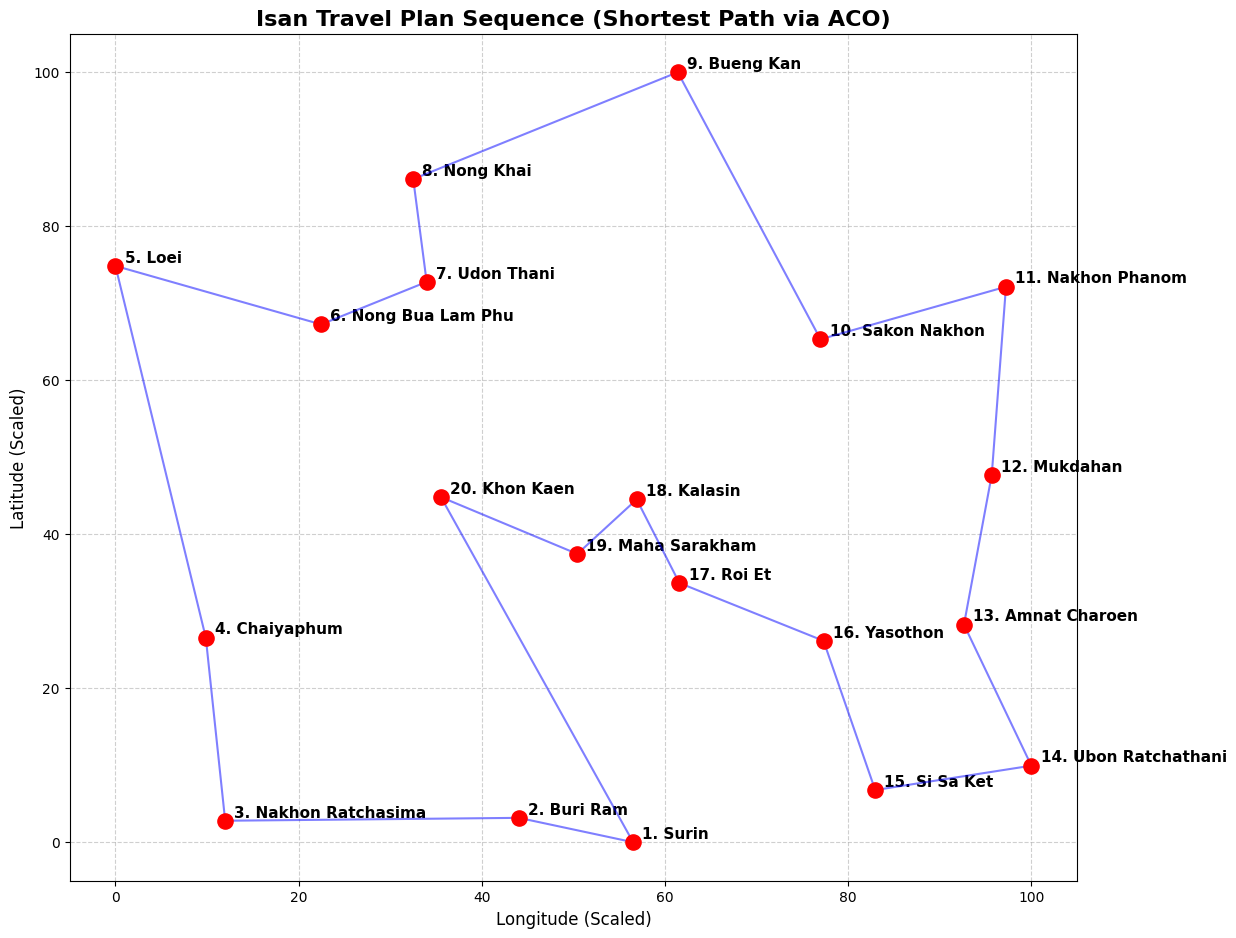

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# 1. สร้างดิกชันนารีสำหรับกรองและแปลงชื่อจังหวัดภาษาไทยเป็นภาษาอังกฤษ
isan_province_map = {
    "กาฬสินธุ์": "Kalasin",
    "ขอนแก่น": "Khon Kaen",
    "ชัยภูมิ": "Chaiyaphum",
    "นครพนม": "Nakhon Phanom",
    "นครราชสีมา": "Nakhon Ratchasima",
    "บึงกาฬ": "Bueng Kan",
    "บุรีรัมย์": "Buri Ram",
    "มหาสารคาม": "Maha Sarakham",
    "มุกดาหาร": "Mukdahan",
    "ยโสธร": "Yasothon",
    "ร้อยเอ็ด": "Roi Et",
    "เลย": "Loei",
    "ศรีสะเกษ": "Si Sa Ket",
    "สกลนคร": "Sakon Nakhon",
    "สุรินทร์": "Surin",
    "หนองคาย": "Nong Khai",
    "หนองบัวลำภู": "Nong Bua Lam Phu",
    "อำนาจเจริญ": "Amnat Charoen",
    "อุดรธานี": "Udon Thani",
    "อุบลราชธานี": "Ubon Ratchathani"
}

# 2. อ่านไฟล์และกรองข้อมูลเฉพาะภาคอีสาน 20 จังหวัด
df = pd.read_csv('provinces.csv')
df_isan = df[df['province_name'].isin(isan_province_map.keys())].reset_index(drop=True)
df_isan['english_name'] = df_isan['province_name'].map(isan_province_map)

# 3. ดึงพิกัด (Longitude, Latitude) และชื่อจังหวัดเก็บไว้ในลิสต์
locations = df_isan[['province_lon', 'province_lat']].values
labels_en = df_isan['english_name'].tolist()
labels_th = df_isan['province_name'].tolist()

# 4. Scale พิกัดให้อยู่ในสเกล 0-100 เพื่อให้คณิตศาสตร์ของ ACO คำนวณได้มีประสิทธิภาพสูงสุด
scaler_lon = MinMaxScaler(feature_range=(0, 100))
scaler_lat = MinMaxScaler(feature_range=(0, 100))
locations[:, 0] = scaler_lon.fit_transform(locations[:, 0].reshape(-1, 1)).flatten()
locations[:, 1] = scaler_lat.fit_transform(locations[:, 1].reshape(-1, 1)).flatten()

if __name__ == '__main__':
    # 5. ตั้งค่าพารามิเตอร์ ACO สำหรับ 20 จังหวัด
    _colony_size = 20
    _steps = 100
    
    # 6. เรียกใช้คลาส SolveTSPUsingACO (คลาสจากใน Notebook ของคุณ)
    acs = SolveTSPUsingACO(
        mode='ACS', 
        colony_size=_colony_size, 
        steps=_steps, 
        nodes=locations, 
        labels=labels_en,
        alpha=1.0,
        beta=3.0,
        rho=0.1
    )
    
    # 7. เริ่มรันโมเดลเพื่อหาเส้นทางที่สั้นที่สุด
    print("Running Ant Colony Optimization for Isan Provinces...")
    time_taken, dist = acs.run()
    route_indices = acs.global_best_tour
    
    # 8. แสดงผลลัพธ์เชิงตัวเลขและข้อความ
    print(f'\nRuntime: {time_taken:.2f} seconds')
    print(f'Minimum scaled distance: {dist:.2f}')
    
    print("\n--- Travel Plan Sequence (English) ---")
    for step, i in enumerate(route_indices):
        print(f"{step + 1}. {labels_en[i]}")
    print(f"Return -> {labels_en[route_indices[0]]}")

    print("\n--- ลำดับการเดินทาง (ภาษาไทย) ---")
    for step, i in enumerate(route_indices):
        print(f"{step + 1}. {labels_th[i]}")
    print(f"กลับไปที่ -> {labels_th[route_indices[0]]}")
    
    # ==========================================
    # 9. สร้างกราฟแสดงผลพร้อมตัวเลขกำกับ
    # ==========================================
    plt.figure(figsize=(13, 11))
    
    for step, idx in enumerate(route_indices):
        # จุดปัจจุบัน และ จุดถัดไป
        current_node = locations[idx]
        next_idx = route_indices[(step + 1) % len(route_indices)]
        next_node = locations[next_idx]
        
        # วาดจุด (Node)
        plt.scatter(current_node[0], current_node[1], c='red', s=120, zorder=5)
        
        # ลากเส้นเชื่อม (Edge)
        plt.plot([current_node[0], next_node[0]], 
                 [current_node[1], next_node[1]], 
                 c='blue', linestyle='-', alpha=0.5, zorder=4)
        
        # ใส่ตัวเลขกำกับพร้อมชื่อภาษาอังกฤษ
        plt.text(current_node[0] + 1.0, current_node[1] + 0.5, 
                 f"{step + 1}. {labels_en[idx]}", 
                 fontsize=11, fontweight='bold', color='black')

    plt.title("Isan Travel Plan Sequence (Shortest Path via ACO)", fontsize=16, fontweight='bold')
    plt.xlabel("Longitude (Scaled)", fontsize=12)
    plt.ylabel("Latitude (Scaled)", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # บันทึกรูปและแสดงผล
    plt.savefig('isan_travel_plan_sequence.png', bbox_inches='tight', dpi=300)
    plt.show()